In [1]:
%load_ext autoreload
%autoreload 2

import utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pickle import load, dump
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

RANDOM_STATE = 42

## Carregar dados / separar em treino e teste

In [2]:
with open('data/wine_quality_fixed.pkl', 'rb') as file:
    wine_data = load(file) 

In [3]:
y = wine_data.quality
X = wine_data.drop(['quality'], axis=1)

In [4]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

## Pré-processamento

Aqui, aplicaremos transformações para aproximar a distribuição dos dados para uma gaussiana simétrica. Além disso, as variáveis numéricas serão centralizadas e escaladas para que seus valores estejam no mesmo intervalo (passo necessário para a maioria dos modelos de machine learning). A coluna **type**, categórica, será transformada em uma flag {0, 1} para poder entrar no modelo.

In [5]:
kurtosis_vars = abs(X_treino.kurtosis())
kurtosis_vars = list(kurtosis_vars[kurtosis_vars > 3].index)

label_vars = list(X_treino.select_dtypes(include=['object']).columns)

scale_vars = [col for col in X_treino.columns if col not in [*kurtosis_vars, *label_vars]]

In [6]:
preprocessing = ColumnTransformer(
    [("encode_categorical", OrdinalEncoder(), label_vars),
     ("scale", StandardScaler(copy=False), scale_vars),
     ("gaussianize", PowerTransformer(copy=False), kurtosis_vars)])

## Modelo ElasticNet

Os coeficientes de um modelo de regressão tendem a "estourar" (assumir valores muito altos) quando há correlação entre os preditores, interferindo na qualidade das predições. Para contornar esse problema, usaremos a regressão *ElasticNet* que adiciona um termo de regularização dos coeficientes, forçando-os a assumir valores próximos de 0. Isso também ajuda a evitar o **overfitting**. O método de validação cruzada *k-fold* com k=5 será usado para seleção dos hiperparâmetros $\alpha$ e l1_ratio.

In [7]:
elasticnet = make_pipeline(preprocessing, ElasticNetCV(l1_ratio=np.linspace(0.01, 1, 50), cv=5, random_state=RANDOM_STATE, n_jobs=-1))
elasticnet = elasticnet.fit(X_treino, y_treino)

## Coeficientes do modelo

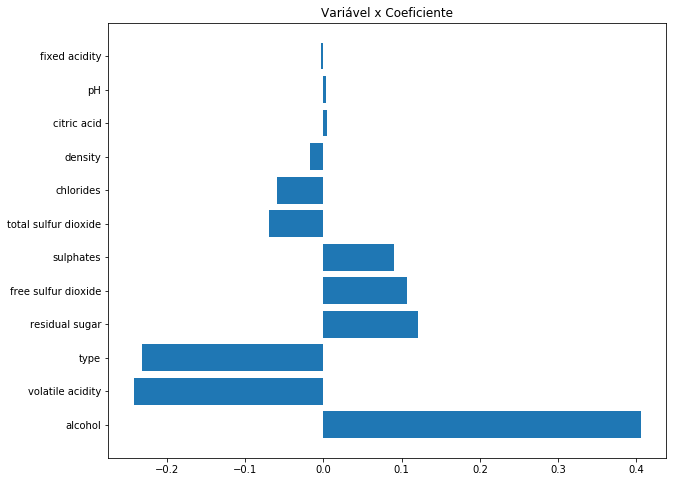

In [8]:
coefs = utils.get_coefs([*label_vars, *scale_vars, *kurtosis_vars], elasticnet.named_steps['elasticnetcv'].coef_)
utils.plot_coef_hbar(coefs)

Como as variáveis estão na mesma escala, podemos assumir que o coeficiente da variável é equivalente à sua importância para o modelo. Conforme visto na análise exploratória, **alcohol** e **volatile acidity** apresentam os maiores coeficientes, com maior impacto na qualidade do vinho.

## RMSE treino / teste

In [9]:
pred_treino = elasticnet.predict(X_treino)
pred_teste  = elasticnet.predict(X_teste)

In [10]:
rmse_treino = utils.rmse(y_treino, pred_treino)
rmse_teste  = utils.rmse(y_teste, pred_teste)

In [11]:
print(f'rmse treino: {rmse_treino:.3f}')
print(f'rmse teste:  {rmse_teste:.3f}')

rmse treino: 0.732
rmse teste:  0.747


A raíz do erro quadrático médio é muito similar entre as bases de treino e teste, indicando que não houve overfitting, e está com um valor baixo em relação à escala da resposta (**quality**). Essa métrica mede a distância dos erros da predição em relação à reta ajustada pelo modelo, ou seja: estamos errando na predição, em média, 0.74 pontos em relação ao valor verdadeiro.

Vamos ajustar dois modelos nulos, prevendo a média e mediana dos valores de **quality** na base de treino para todas as observações da base de teste.

## RMSE modelos dummy

In [12]:
modelo_media   = DummyRegressor(strategy='mean')
modelo_mediana = DummyRegressor(strategy='median')

In [13]:
modelo_media   = modelo_media.fit(X_treino, y_treino)
modelo_mediana = modelo_mediana.fit(X_treino, y_treino)

In [14]:
pred_media   = modelo_media.predict(X_teste)
pred_mediana = modelo_mediana.predict(X_teste)

In [15]:
rmse_media   = utils.rmse(y_teste, pred_media)
rmse_mediana = utils.rmse(y_teste, pred_mediana)

In [16]:
print(f'rmse media:   {rmse_media:.3f}')
print(f'rmse mediana: {rmse_mediana:.3f}')

rmse media:   0.874
rmse mediana: 0.892


O *rmse* nos dois modelos ficou em torno de 0.88. Nosso *ElasticNet* está melhor do que modelos aleatórios, mas os valores não estão significativamente distantes. Isso pode ser devido à natureza dos dados, pois a percepção sensorial da qualidade de um vinho é muito subjetiva e é influenciada por muito mais fatores do que simplesmente as propriedades físicas do produto.

## Salvando modelo

In [17]:
with open('model/elasticnet.pkl', 'wb') as file:
    dump(elasticnet, file)